In [15]:
from fit_completeness_to_catalog import *
import os
name = "sullivan"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected 907 stars


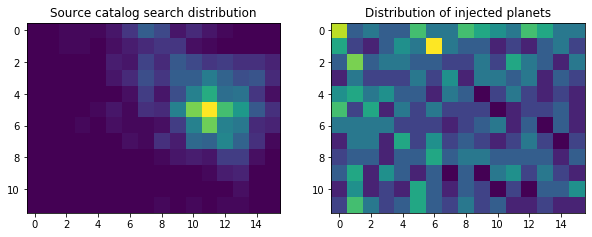

Injected 575 transiting planets


In [27]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 10000
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

In [28]:
N = hist_synth
D = hist_catalog
log_fact_D = special.gammaln(D + 1)
comp_poly = lambda x, a1, a2, a3, a4: a4 + a1 * x + (a1 * a2) * x ** 2 + (a1/3) * (a2**2 + a3**2) * x ** 3
 
def ll_no_prior(a):
    a_period, a_radius = a[:4], a[4:]
    comp_p, comp_r = comp_poly(bins_p[:-1], *a_period), comp_poly(bins_r[:-1], *a_radius)
    has_negative = np.any(comp_p < 0) or np.any(comp_r < 0)
    if has_negative:
        return -np.inf
    if False:
        if np.any(comp_p > 1) or np.any(comp_r > 1):
            return -np.inf
    comp = np.outer(comp_p, comp_r)
    if np.any(comp < 0):
        return -np.inf
    mu = N * comp
    if np.any(mu < 0):
        return -np.inf
    mu += eps
    # likelihood_mat = mu ** D * np.exp(-mu) / fact_D
    # return np.nansum(np.log(likelihood_mat))
    ll_mat = D * np.log(mu) - mu - log_fact_D
    return np.sum(ll_mat)

# ll_no_prior([1.1, -0.55, 0.11, -0.01, 0.14, 0.45, 0.4, 0.2])

In [29]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [-1.98205026e-07 -9.49281106e-01 -9.80579919e-01  2.29742710e-01
  1.30054632e+00  6.18311479e-01  3.39545094e-01  1.20200445e+00]
Set initial condition


In [30]:
max_iters = 50
i = 0
while i < max_iters:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        sampler.run_mcmc(np.median(sampler.chain[:,:-1000,:], axis=1), 1000, store=True)
        print(i)
        i += 1

/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


0
1
2


KeyboardInterrupt: 

In [11]:
for i in range(10):
    sampler.run_mcmc(np.median(sampler.chain[:,:-1000,:], axis=1), 1000, store=True)
    print(i)

0
1
2
3
4
5
6
7
8
9


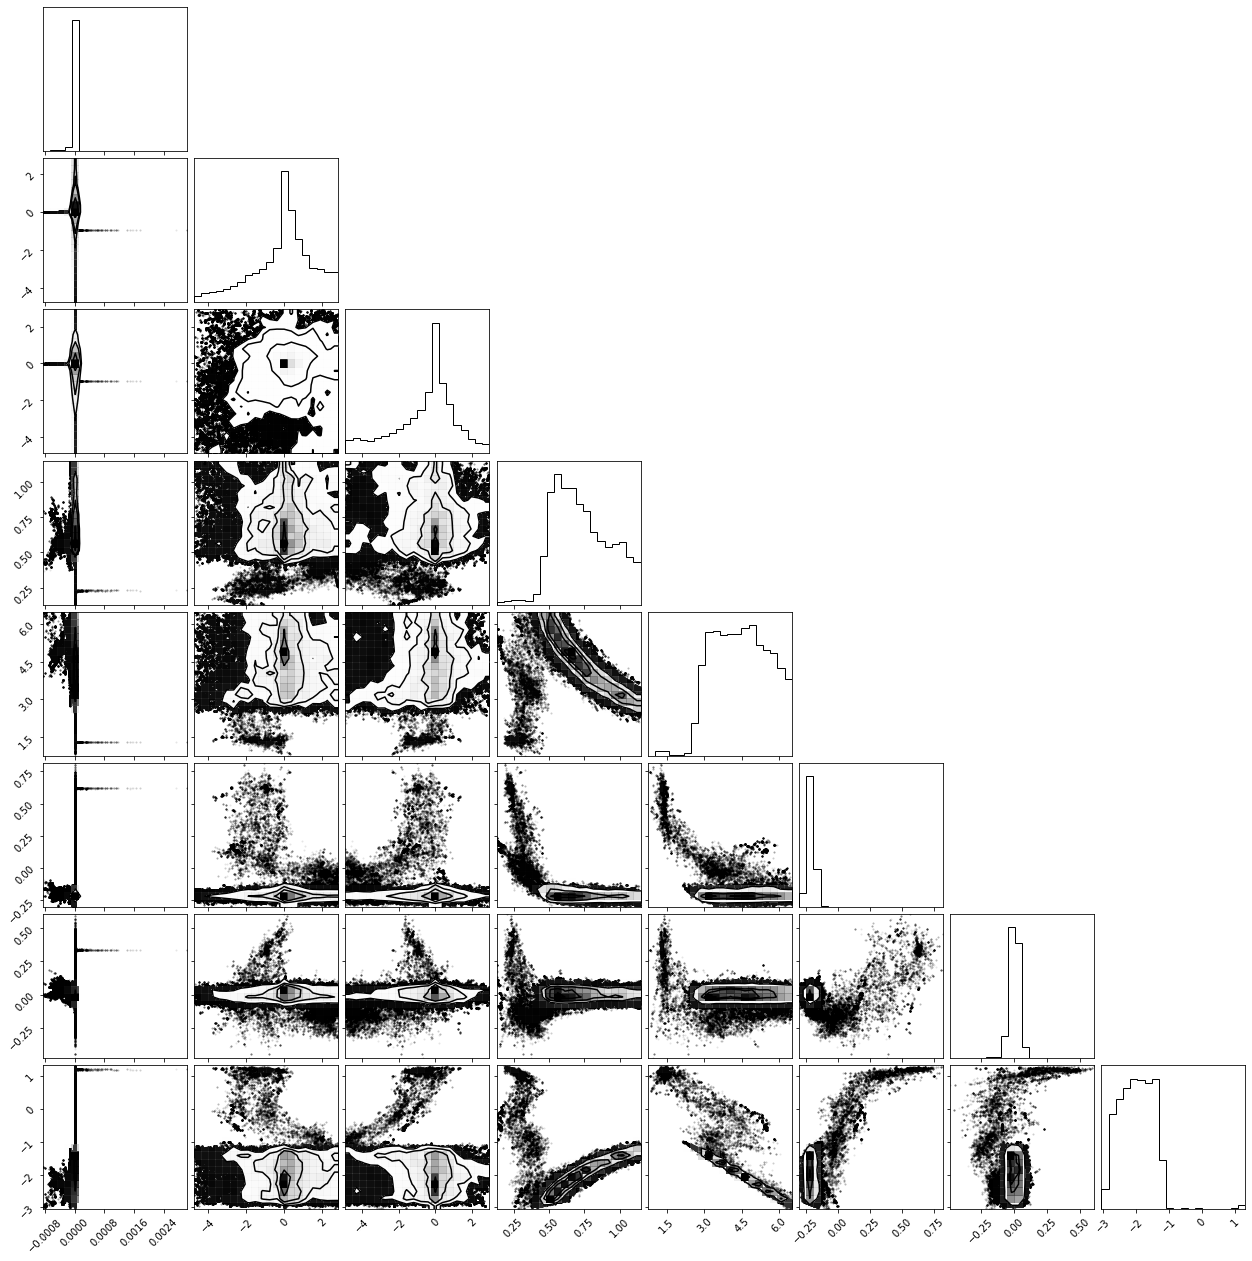

In [31]:
_ = corner.corner(sampler.flatchain) # check autocorrelation times

In [32]:
from IPython.display import display, Math
labels = ['p0', 'p1', 'p2', 'p3', 'r0', 'r1', 'r2', 'r3']

best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=100, thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))
    
ll(best_params)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

-1668.9717629015975

In [33]:
ll(np.array([1.1, -0.55, 0.11, -0.01, 0.14, 0.45, 0.4, 0.2]))

-inf

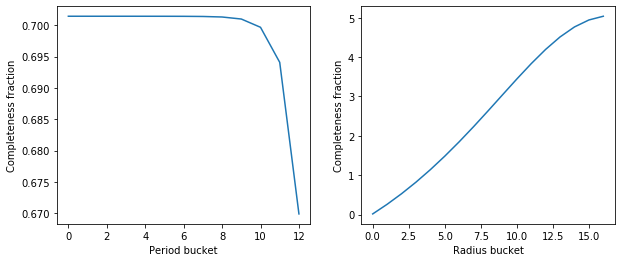

In [34]:
plot_marginalized_comps(best_params)
# cut off days at 27, or at 90th percentile for TOIs

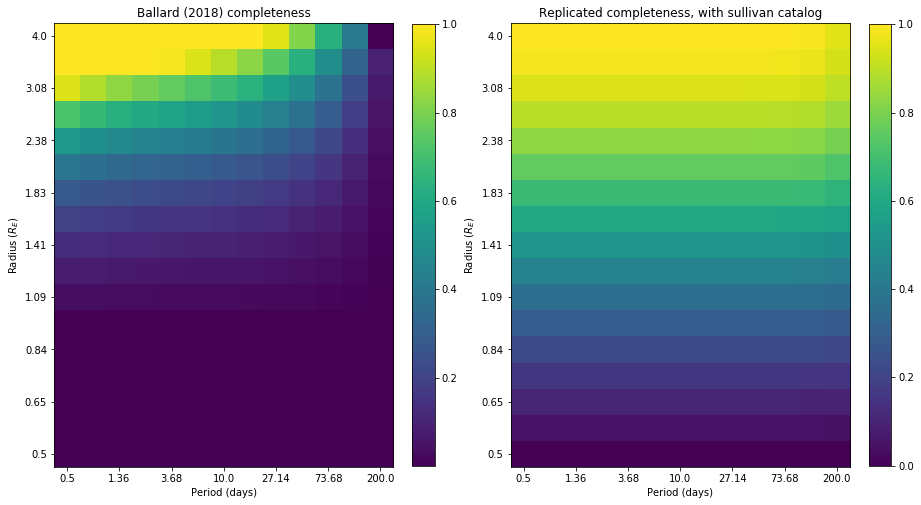

In [35]:
repcomp = np.outer(comp_poly(bins_p, *best_params[:4]), comp_poly(bins_r, *best_params[4:])).T
repcomp -= np.min(repcomp)
repcomp /= np.max(repcomp)
plot_overall_comps(repcomp, name)